# ML for Fusion Peptide 

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import dweibull
from propy import PyPro
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import BaggingClassifier

In [2]:
random.seed(4)

## Data Preprocessing

In [3]:
positive_seqs = pd.read_csv("/root/ProteinFeatureEngineering/data/positive.csv")['sequence'].to_list()
positive_seqs = [seq.replace('(','').replace(')','') for seq in positive_seqs if type(seq) is str]

positive_seqs = [seq for seq in positive_seqs if len(seq)>5]

print("pos len:", len(positive_seqs))

pos len: 433


In [4]:
def distribution(data):
    plt.figure(figsize=(3,2))
    sns.distplot(data)
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

/tmp/ipykernel_24733/1753450598.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


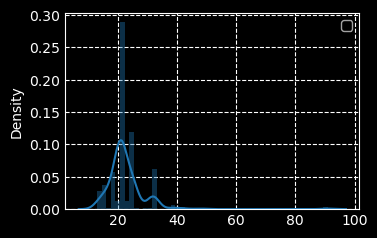

In [5]:
plt.style.use('_mpl-gallery')

# make data
y = [len(seq) for seq in positive_seqs if type(seq) is str]
# print(y)
distribution(y)


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.160266] [loc=22.758 scale=6.875]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.17728] [loc=13.000 scale=9.758]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.17728] [loc=-4294967283.000 scale=4294967296.000]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 0.0621287] [loc=21.000 scale=5.919]
[distfit] >INFO> [t         ] [0.11 sec] [RSS: 0.161055] [loc=22.856 scale=6.948]
[distfit] >INFO> [genextreme] [0.04 sec] [RSS: 0.149485] [loc=20.134 scale=4.077]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.152289] [loc=11.872 scale=2.897]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 0.150283] [loc=8.831 scale=12.863]
[distfit] >INFO> [beta      ] [0.07 sec] [RSS: 0.152742] [loc=12.033 scale=2373435273147.932]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.199847] [loc=13.000 scale=78.000]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 0.161943] [loc=-2962.911 scale=378.894]
[distfit] >INFO

{'name': 'dweibull',
 'score': 0.062128658064186305,
 'loc': 20.999999999999996,
 'scale': 5.919494566655677,
 'arg': (0.5735579184883346,),
 'params': (0.5735579184883346, 20.999999999999996, 5.919494566655677),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f107055bc10>,
 'bootstrap_score': 0,
 'bootstrap_pass': None,
 'color': '#e41a1c',
 'CII_min_alpha': -4.340127560163808,
 'CII_max_alpha': 46.340127560163786}

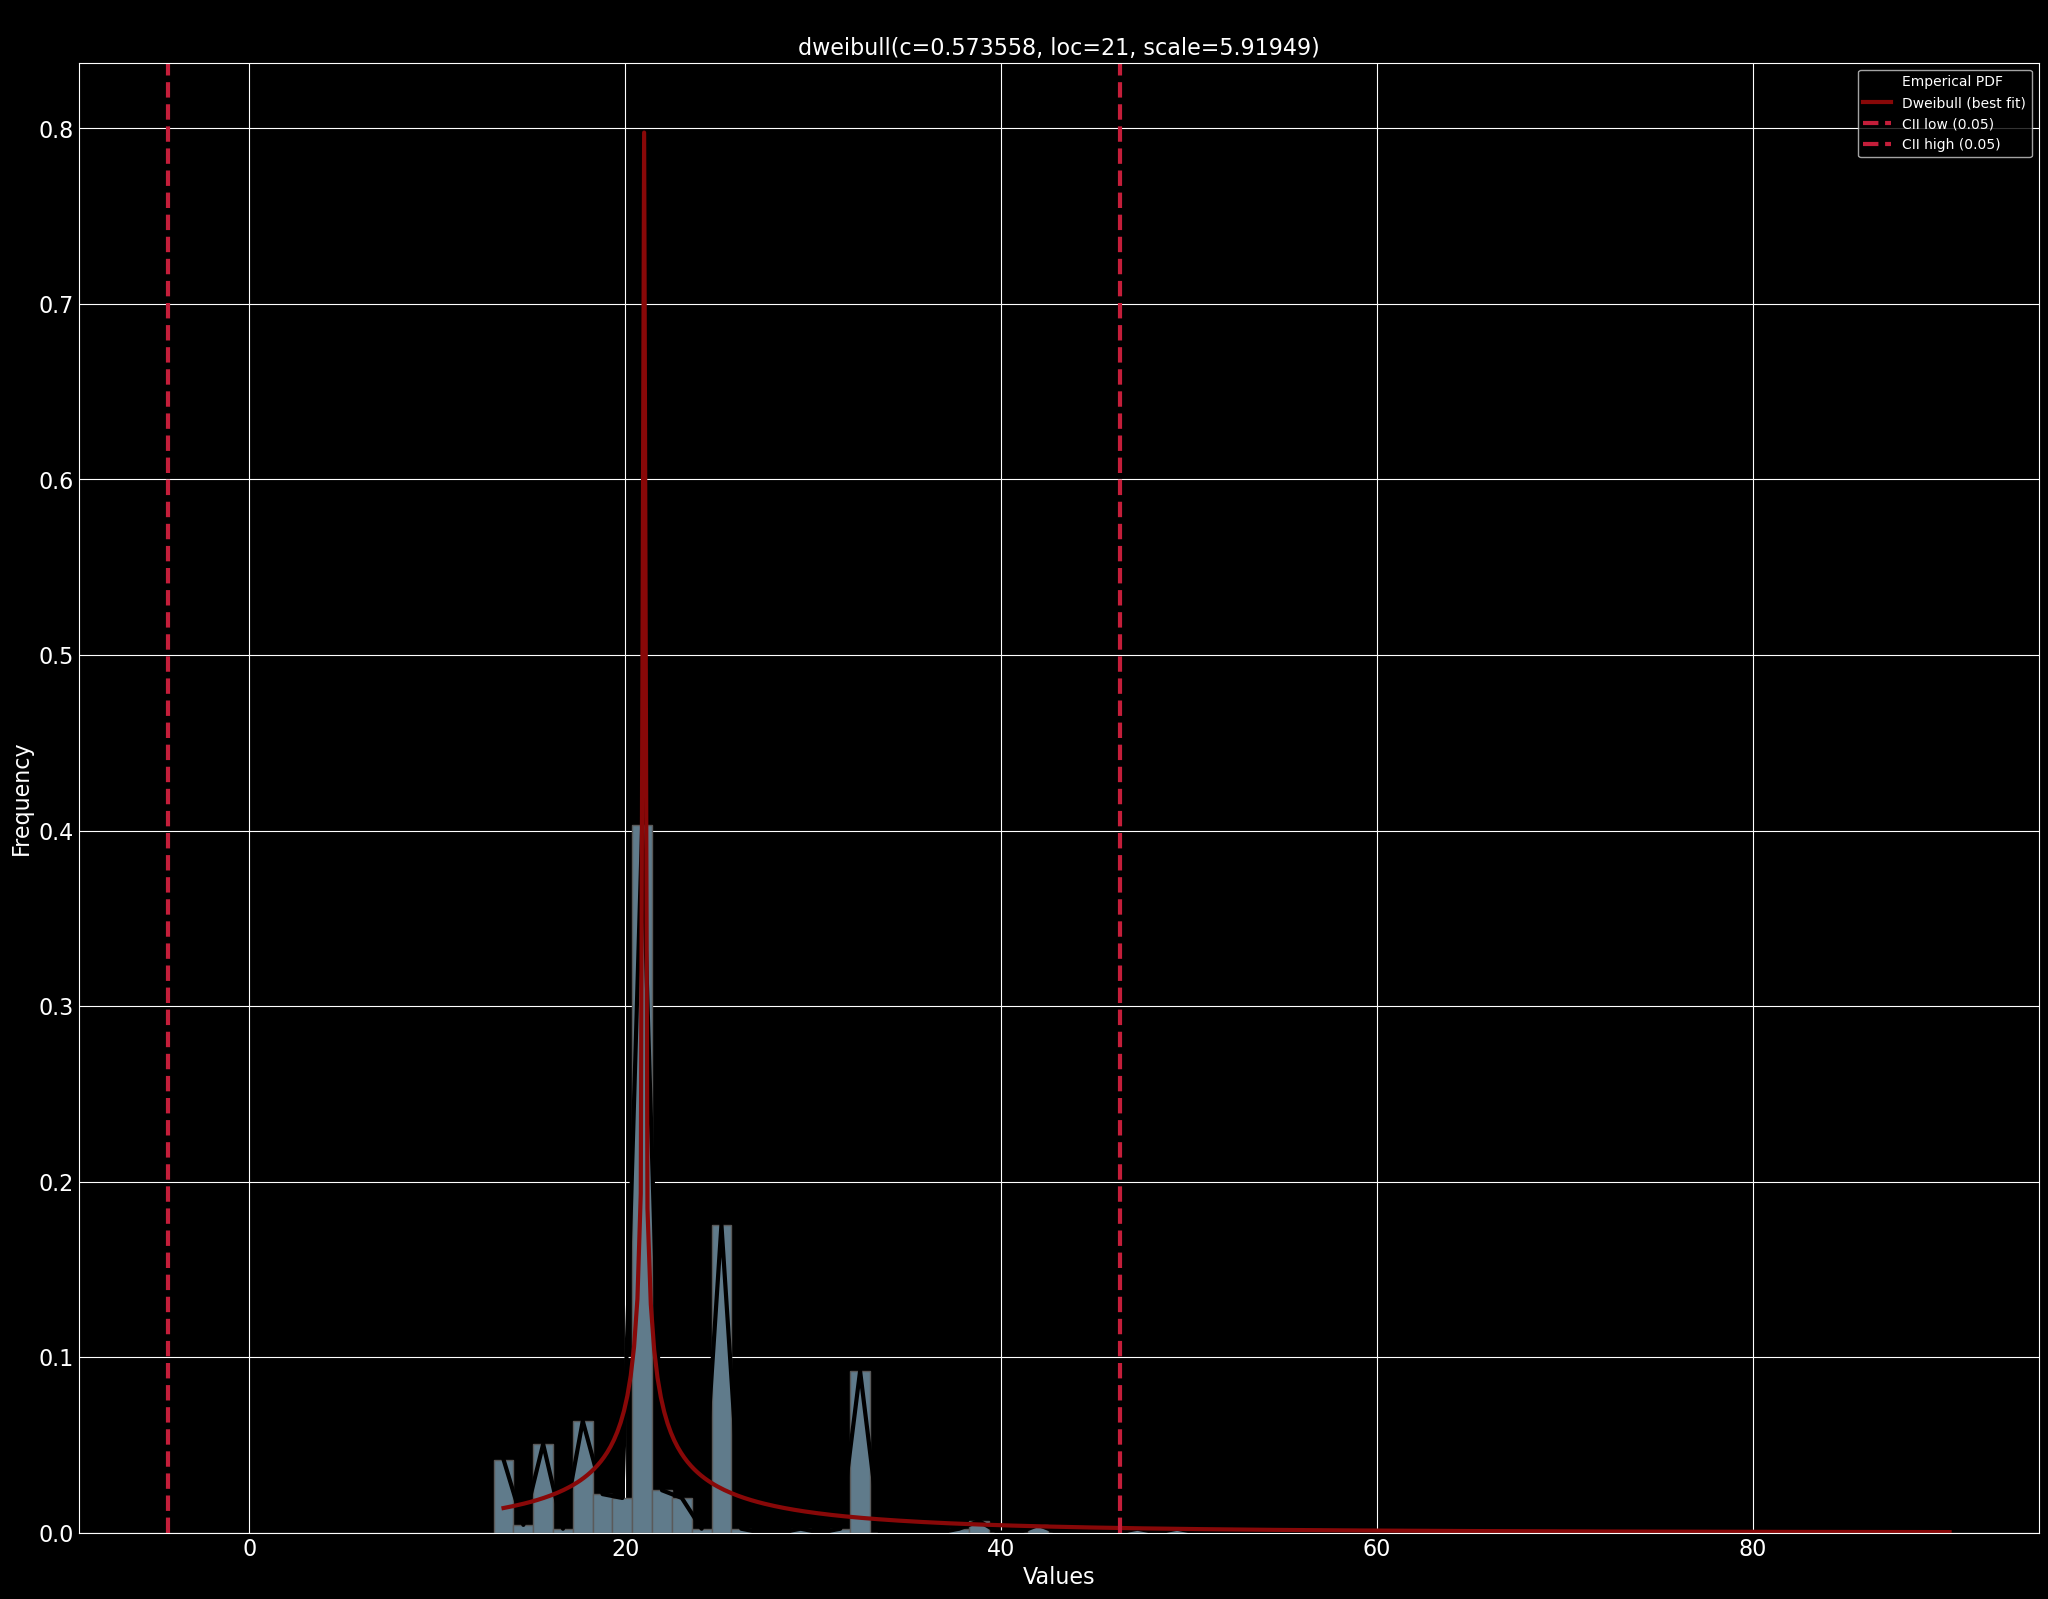

In [6]:
from distfit import distfit
import numpy as np
# X = np.random.normal(0, 2, [100,10])
dist = distfit(todf=True)
dist.fit_transform(np.array(y))
dist.plot()
dist.model

In [7]:
c, loc, scale = (0.5735579184883346, 20.999999999999996, 5.919494566655677)
r = dweibull.rvs(c, loc=loc, scale=scale)
r

20.833411818852632

In [8]:
negative_seqs = pd.read_excel("/root/ProteinFeatureEngineering/data/negative.xlsx")['Sequence'].to_list()
negative_seqs = [seq.replace('(','').replace(')','') for seq in negative_seqs if type(seq) is str]

seqs = []
for seq in negative_seqs:
    seqs+=[seq[i:i+20] for i in range(0, len(seq), 20)]
negative_seqs = seqs

negative_seqs = [seq for seq in negative_seqs if len(seq)>10]

print("neg len:", len(negative_seqs))

neg len: 386


## Descriptor generation

In [9]:
def generate_feature(sequence):
    DesObject = PyPro.GetProDes(sequence)  # construct a GetProDes object
    feature_value = []
    feature_value = list(DesObject.GetAAComp().values()) # AAC
    feature_value += list(DesObject.GetDPComp().values()) # DPC
    feature_value += list(DesObject.GetTPComp().values()) # TPC
    feature_value += list(DesObject.GetMoreauBrotoAuto().values()) # MBauto
    feature_value += list(DesObject.GetMoranAuto().values())  # Moranauto
    feature_value += list(DesObject.GetGearyAuto().values()) # Gearyauto
    feature_value += list(DesObject.GetCTD().values()) # CTD
    feature_value += list(DesObject.GetSOCN().values()) # SOCN
    feature_value += list(DesObject.GetQSO().values()) # QSO
    feature_value += list(DesObject.GetPAAC().values()) # PAAC
    feature_value += list(DesObject.GetAPAAC().values()) # APAAC
    
    return feature_value

In [10]:
feature_list = []
DesObject = PyPro.GetProDes(positive_seqs[0]) 
feature_list += DesObject.GetAAComp().keys() # AAC
feature_list += DesObject.GetDPComp().keys() # DPC
feature_list += DesObject.GetTPComp().keys() # TPC
feature_list += DesObject.GetMoreauBrotoAuto().keys() # MBauto
feature_list += DesObject.GetMoranAuto().keys()  # Moranauto
feature_list += DesObject.GetGearyAuto().keys() # Gearyauto
feature_list += DesObject.GetCTD().keys() # CTD
feature_list += DesObject.GetSOCN().keys() # SOCN
feature_list += DesObject.GetQSO().keys() # QSO
feature_list += DesObject.GetPAAC().keys() # PAAC
feature_list += DesObject.GetAPAAC().keys() # APAAC

In [11]:
DesObject.GetGearyAuto().keys()

dict_keys(['GearyAuto_Hydrophobicity1', 'GearyAuto_Hydrophobicity2', 'GearyAuto_Hydrophobicity3', 'GearyAuto_Hydrophobicity4', 'GearyAuto_Hydrophobicity5', 'GearyAuto_Hydrophobicity6', 'GearyAuto_Hydrophobicity7', 'GearyAuto_Hydrophobicity8', 'GearyAuto_Hydrophobicity9', 'GearyAuto_Hydrophobicity10', 'GearyAuto_Hydrophobicity11', 'GearyAuto_Hydrophobicity12', 'GearyAuto_Hydrophobicity13', 'GearyAuto_Hydrophobicity14', 'GearyAuto_Hydrophobicity15', 'GearyAuto_Hydrophobicity16', 'GearyAuto_Hydrophobicity17', 'GearyAuto_Hydrophobicity18', 'GearyAuto_Hydrophobicity19', 'GearyAuto_Hydrophobicity20', 'GearyAuto_Hydrophobicity21', 'GearyAuto_Hydrophobicity22', 'GearyAuto_Hydrophobicity23', 'GearyAuto_Hydrophobicity24', 'GearyAuto_Hydrophobicity25', 'GearyAuto_Hydrophobicity26', 'GearyAuto_Hydrophobicity27', 'GearyAuto_Hydrophobicity28', 'GearyAuto_Hydrophobicity29', 'GearyAuto_Hydrophobicity30', 'GearyAuto_AvFlexibility1', 'GearyAuto_AvFlexibility2', 'GearyAuto_AvFlexibility3', 'GearyAuto_AvF

In [14]:
X = []
y = [1]*len(positive_seqs)+[0]*len(negative_seqs)

for sequence in positive_seqs:
    feature_value = generate_feature(sequence)
    X.append(feature_value)  # calculate 147 CTD descriptors

for sequence in negative_seqs:
    feature_value = generate_feature(sequence)
    X.append(feature_value)  # calculate 147 CTD descriptors


## Filter descriptor by variance

In [15]:
var_thres = VarianceThreshold(threshold=0.05)
var_thres.fit(X)

VarianceThreshold(threshold=0.05)

In [16]:
X_varthresh = np.array(X)[:,var_thres.get_support(indices=True)]

In [17]:
feature_list = np.array(feature_list)[var_thres.get_support(indices=True)]

In [18]:
len(X[0])

9547

In [19]:
len(X_varthresh[0])

1275

## Feature selection

In [20]:
X_zscored_varthresh = stats.zscore(X_varthresh)

In [21]:
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=12, step=1)

clf = BaggingClassifier(estimator=selector, n_estimators=15).fit(X_zscored_varthresh, y)
clf.predict
# for i, (train_index, test_index) in enumerate(kf.split(X_zscored_varthresh)):
#     # train 
#     X_train = np.array(X_zscored_varthresh)[train_index]
#     y_train = np.array(y)[train_index]
#     selector = selector.fit(X_train, y_train)
    
#     # test
#     X_test = np.array(X_zscored_varthresh)[test_index]
#     y_test = np.array(y)[test_index]
#     print(f"Fold {i} score: {selector.score(X_test, y_test)}")
#     print(f"Fold {i} selected: {np.where(selector.support_ == True)}")
    

<bound method BaggingClassifier.predict of BaggingClassifier(estimator=RFE(estimator=SVC(kernel='linear'),
                                n_features_to_select=12),
                  n_estimators=15)>

In [22]:
np.where(clf.estimators_[0].support_ == True)

(array([   0,    7,  232,  605,  654,  827,  902,  920,  925, 1001, 1002,
        1218]),)

In [23]:
feature_list = np.array(feature_list)[clf.estimators_[0].support_]
feature_list

array(['A', 'G', 'LF', 'MoreauBrotoAuto_Steric18',
       'MoranAuto_Hydrophobicity20', 'GearyAuto_Hydrophobicity20',
       'GearyAuto_FreeEnergy20', 'GearyAuto_ResidueASA15',
       'GearyAuto_ResidueASA20', 'GearyAuto_Mutability19',
       'GearyAuto_Mutability20', 'PAAC14'], dtype='<U32')

In [24]:
X = np.array(X_zscored_varthresh)[:, clf.estimators_[0].support_]

In [25]:
len(X[0])

12

## SVM classification

In [26]:
regr = make_pipeline(StandardScaler(), SVC(kernel="linear"))
regr.fit(X[:-100], y[:-100])
print("score", regr.score(X[-100:], y[-100:]))

score 0.96


In [27]:
params = zip(feature_list, regr.named_steps['svc'].coef_[0])
params=sorted(params, reverse=True, key=lambda x:(x[1], x[0]))
pd.DataFrame(params).to_csv("params.txt", index=None, header=None)
params

[('MoranAuto_Hydrophobicity20', 1.764239641446494),
 ('GearyAuto_ResidueASA20', 1.710747647817542),
 ('GearyAuto_Hydrophobicity20', 1.2301503299246457),
 ('PAAC14', 1.1627451720944564),
 ('A', 1.0657404795454688),
 ('G', 1.039167652485272),
 ('GearyAuto_Mutability20', 0.948294859612485),
 ('GearyAuto_FreeEnergy20', 0.538968736906946),
 ('LF', 0.4783717282916247),
 ('MoreauBrotoAuto_Steric18', -0.43355078766078536),
 ('GearyAuto_ResidueASA15', -0.5651224674582123),
 ('GearyAuto_Mutability19', -1.4571517481706453)]

In [28]:
no_auto_index = [False]*4 + [True]*3 + [False] + [True]*4

In [29]:
no_auto_X = np.array(X)[:, no_auto_index]

In [30]:
regr = make_pipeline(StandardScaler(), SVC(kernel="linear"))
regr.fit(no_auto_X, y)
print("score", regr.score(no_auto_X, y))

score 0.8888888888888888
